#  COVID skiepai vs. mirtingumas

Šioje duomenų lentelėje pateikiami pasaulio (198 šalių) COVID vakcinacijos ir mirčių nuo COVID duomenys laikotarpiu nuo 2020-12-13 iki 2021-12-26. Duomenų rinkinio eilutė parodo, kiek konkrečią dieną buvo iš viso vakcinuotų žmonių konkrečioje šalyje, kiek užfiksuota naujų mirčių, tos šalies populiacija bei procentas vakcinuotų žmonių, lyginant su populiacija.

Analizės tikslas- paruošti duomenis analizei ir juos išanalizuoti pasitelkiant tiesinės regresijos modelį.

## Susipažinimas su duomenimis ir jų paruošimas

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import pylab as pl
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
%matplotlib inline
import matplotlib as mpl
from scipy import stats
import seaborn as sns

In [2]:
df = pd.read_csv('covid-vaccination-vs-death_ratio.csv')

In [3]:
df.head()

,Unnamed: 0,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,New_deaths,population,ratio
0,0,Afghanistan,AFG,2021-05-11,504502.0,448878.0,55624.0,12,40295077.0,1.113977
1,1,Afghanistan,AFG,2021-05-20,547901.0,470341.0,77560.0,10,40295077.0,1.167242
2,2,Afghanistan,AFG,2021-05-24,573277.0,476367.0,96910.0,10,40295077.0,1.182197
3,3,Afghanistan,AFG,2021-05-26,590454.0,479372.0,111082.0,19,40295077.0,1.189654
4,4,Afghanistan,AFG,2021-05-27,593313.0,479574.0,113739.0,14,40295077.0,1.190155


In [4]:
#Stulpelių reikšmės:
#country- šalis
#iso_code- šalies kodas
#date- duomenų įvedimo data
#total_vaccinations- kiekis (iš viso) COVID skiepo dozių
#people_vaccinated-kiekis žmonių, paskiepytų bent viena doze
#people_fully_vaccinated-kiekis žmonių,kurie askiepyti 2 dozėmis
#New_deaths- tą dieną mirusių nuo Covid skaičius
#population- 2021 m. populiacija
#ratio-procentas paskiepytų žmonių (people_vaccinated/population)

In [5]:
#duomenų tvarkymas, nereikalingo stulpelio pašalinimas

df.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
len(df) #įrašų (eilučių) skaičius

26623

In [7]:
len(df['country'].unique())

198

In [8]:
len(df['iso_code'].unique()) #patikrinu, ar country ir iso_code sutampa, jei taip, iso_code stulpelis nebus reikalingas

198

In [9]:
df.drop('iso_code', axis=1, inplace=True)

In [10]:
df.isnull().sum() #duomenys neturi nulinių reikšmių

country                    0
date                       0
total_vaccinations         0
people_vaccinated          0
people_fully_vaccinated    0
New_deaths                 0
population                 0
ratio                      0
dtype: int64

In [11]:
df.describe().round(2)

,total_vaccinations,people_vaccinated,people_fully_vaccinated,New_deaths,population,ratio
count,2.662300e+04,2.662300e+04,2.662300e+04,26623.00,2.662300e+04,26623.00
mean,2.624900e+07,1.587149e+07,1.015975e+07,104.34,5.068306e+07,36.06
std,9.172916e+07,5.852142e+07,3.409173e+07,343.70,1.585035e+08,27.29
min,1.000000e+00,1.000000e+00,1.000000e+00,-92.00,1.373000e+03,0.00
25%,6.062655e+05,4.006990e+05,1.765970e+05,1.00,3.354825e+06,9.94
50%,3.570392e+06,2.248865e+06,1.169177e+06,10.00,1.034502e+07,32.82
75%,1.560763e+07,8.804162e+06,5.698058e+06,52.00,3.823269e+07,60.42
max,2.422908e+09,1.225000e+09,1.076308e+09,8786.00,1.446645e+09,122.15


In [12]:
#Įžvalgos:
#1.Laikotarpiu nuo 2020-12-13 iki 2021-12-26 užfiksuota 26623000 mirčių nuo COVID pasaulyje;
#2. Apie 36 % pasaulio populiacijos paskiepyta laikotarpiu nuo 2020-12-13 iki 2021-12-26.
#3.Yra šalis, kuri deklaravo daugiau paskiepytų nei populiacija.
#4. Vidutiniškai per dieną nuo COVID pasaulyje mirė virš 100000  žmonių.

In [13]:
df.info() #duomenų tipai

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26623 entries, 0 to 26622
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   country                  26623 non-null  object 
 1   date                     26623 non-null  object 
 2   total_vaccinations       26623 non-null  float64
 3   people_vaccinated        26623 non-null  float64
 4   people_fully_vaccinated  26623 non-null  float64
 5   New_deaths               26623 non-null  int64  
 6   population               26623 non-null  float64
 7   ratio                    26623 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 1.6+ MB


In [14]:
df['country'].value_counts() #parodo, kaip dažnai duomenis atnaujino šalys

United States of America       376
Israel                         373
Canada                         369
Switzerland                    367
Germany                        364
                              ... 
Tuvalu                           4
Niue                             2
Turkmenistan                     2
Falkland Islands (Malvinas)      2
Tokelau                          1
Name: country, Length: 198, dtype: int64

In [53]:
df['population'].unique().sum() #total population in this dataset

7706449642.0

In [15]:
df.groupby('country') [['New_deaths']].sum().sort_values('New_deaths',ascending=False) 

,New_deaths
country,
United States of America,501036
Brazil,390913
India,309859
Russian Federation,193712
Mexico,121932
...,...
Comoros,0
Solomon Islands,0
Burundi,0


In [ ]:
#Kadangi naujų mirčių statistika nesusieta su populiacija, 
#sukursiu naują stulpelį,kad galėtume palyginti:

In [16]:
df['deaths_ratio']=df['New_deaths']/ df['population']

In [17]:
df.groupby('country') [['deaths_ratio']].sum().sort_values('deaths_ratio',ascending=False)[0:20]

,deaths_ratio
country,
Peru,0.002809
Slovakia,0.002338
Latvia,0.002086
Hungary,0.002027
Brazil,0.001821
Lithuania,0.001808
Montenegro,0.001793
Paraguay,0.001757
Argentina,0.001535


In [ ]:
#Top20 šalių, kur mirtingumas didžiausias nuo COVID

In [18]:
maxrating=df.groupby('country') [['country','ratio']].max().sort_values('ratio',ascending=False)

In [19]:
maxrating

,country,ratio
country,,
Gibraltar,Gibraltar,122.149682
Malta,Malta,99.307358
United Arab Emirates,United Arab Emirates,98.484635
Cuba,Cuba,91.873382
Brunei Darussalam,Brunei Darussalam,91.328883
...,...,...
South Sudan,South Sudan,1.980167
Yemen,Yemen,1.805868
Chad,Chad,1.666099


In [ ]:
#Geriausią reitingą pasiekė šios šalys. Gibraltaras skiepijo ir Ispanijos piliečius, dėl to deklaravo 
#daugiau pasiskiepijusiųjų nei jų populiacija.

## Duomenų vizualizavimas

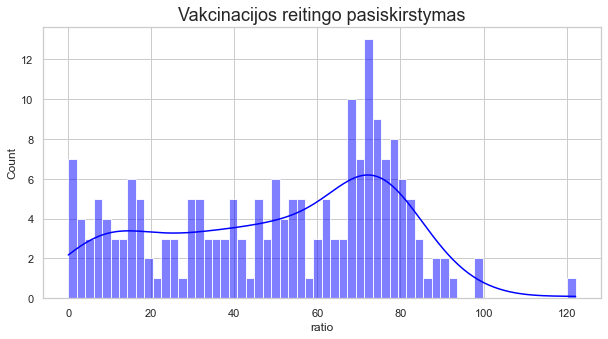

In [20]:
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style('whitegrid')
sns.histplot(maxrating['ratio'], bins= 60,kde='True', color="blue")
plt.title("Vakcinacijos reitingo pasiskirstymas", fontsize=18);

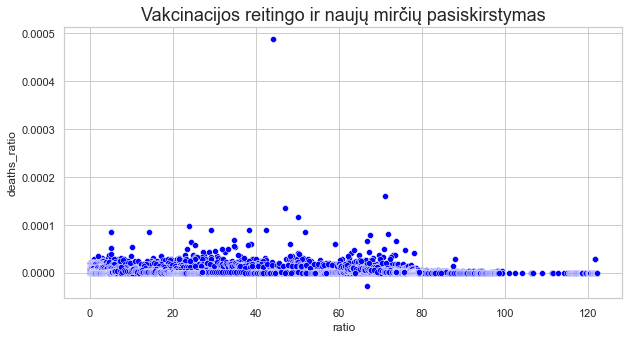

In [21]:
sns.scatterplot(x = 'ratio', y = 'deaths_ratio', data=df, color="blue")
plt.title("Vakcinacijos reitingo ir naujų mirčių pasiskirstymas", fontsize=18);

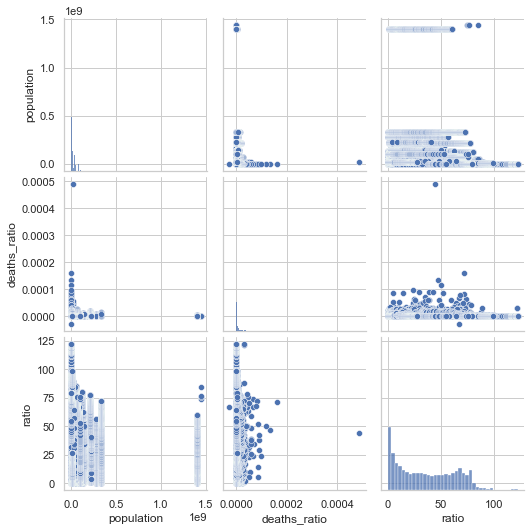

In [22]:
sns.pairplot(df, palette="husl", vars = [ 'population',
 'deaths_ratio',
 'ratio'])

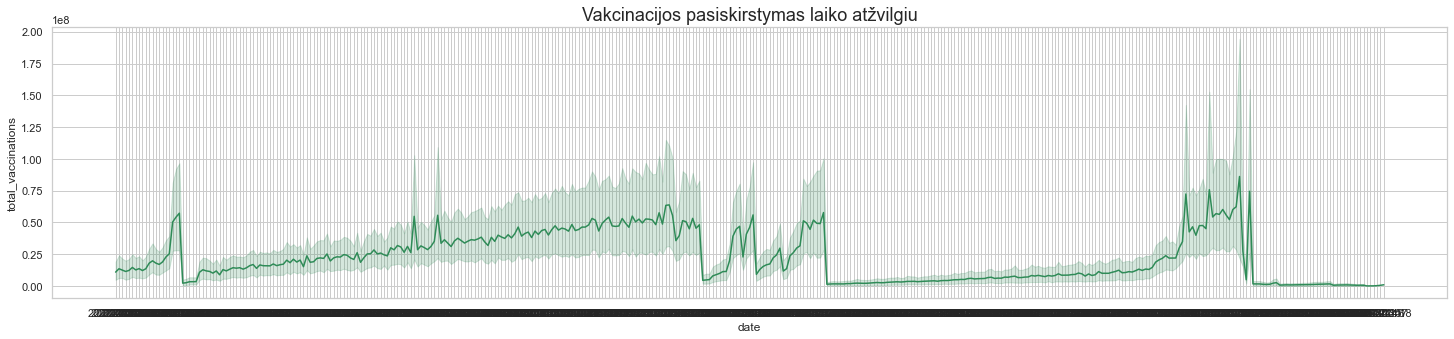

In [23]:
sns.set(rc={'figure.figsize':(25,5)})
sns.set_style('whitegrid')
sns.lineplot(data=df, x="date", y="total_vaccinations", color="seagreen")
plt.title("Vakcinacijos pasiskirstymas laiko atžvilgiu", fontsize=18);

C:\Users\ingri\AppData\Local\Temp/ipykernel_41292/2857429537.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  meanratio = df.groupby('date') ['date','ratio'].mean()


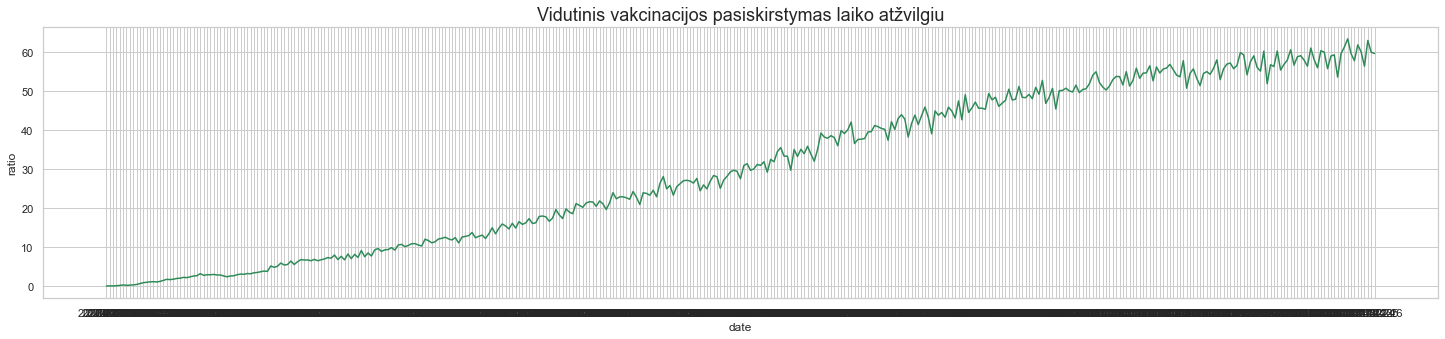

In [24]:
sns.set(rc={'figure.figsize':(25,5)})
sns.set_style('whitegrid')
meanratio = df.groupby('date') ['date','ratio'].mean()
sns.lineplot(data=meanratio, x="date", y="ratio", color="seagreen")
plt.title("Vidutinis vakcinacijos pasiskirstymas laiko atžvilgiu", fontsize=18);

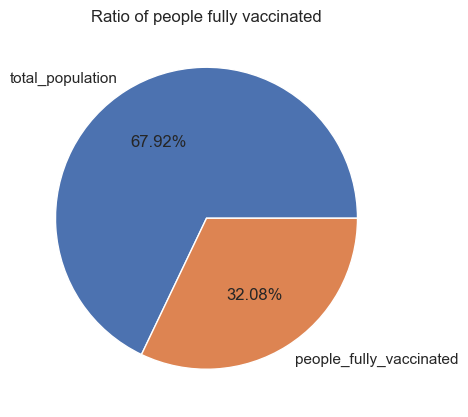

In [54]:
df_country = df.groupby('country').agg({'people_fully_vaccinated':max})
sum_vac_full = df_country['people_fully_vaccinated'].sum()
plt.figure(figsize=(10,5),dpi=100)
plt.pie(
    [total_population,sum_vac_full],
    autopct='%.2F%%',
    labels=['total_population','people_fully_vaccinated'])
plt.title('Ratio of people fully vaccinated')
plt.show()

Text(0.5, 1.0, 'Vakcinacijos reitingas ir naujos mirtys Lietuvoje')

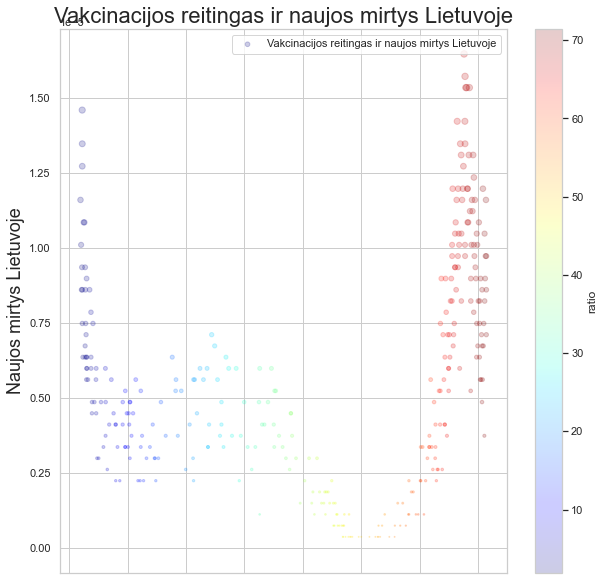

In [25]:
df_Lietuva = df[df['country']=='Lithuania']
df_Lietuva.plot(
    kind='scatter',
    x='ratio',
    y='deaths_ratio',
    label='Vakcinacijos reitingas ir naujos mirtys Lietuvoje',
    alpha=0.2,
    figsize=(10,10),
    s=df_Lietuva['New_deaths'],
    c='ratio',
    cmap=plt.get_cmap('jet'),
    colorbar=True)

plt.xlabel('reitingas(%)',fontsize=15)
plt.ylabel('Naujos mirtys Lietuvoje',fontsize=18)
plt.title('Vakcinacijos reitingas ir naujos mirtys Lietuvoje',fontsize=22)

<AxesSubplot:>

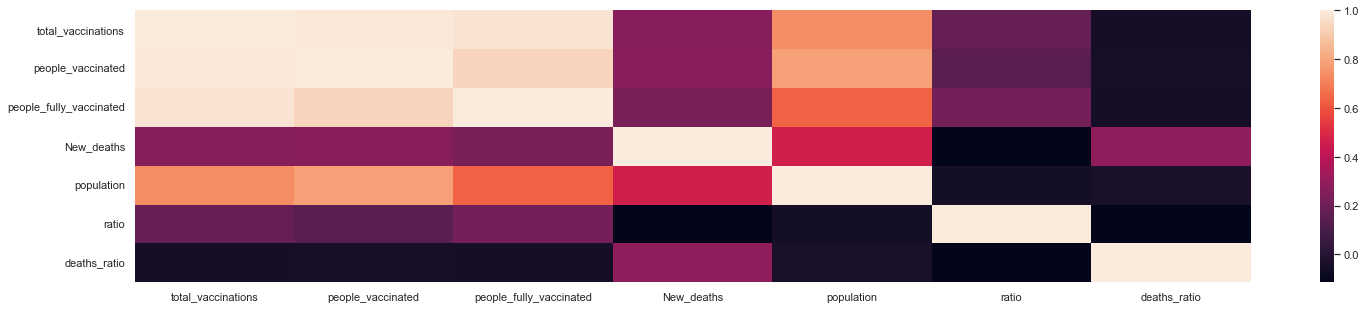

In [26]:
sns.heatmap(df.corr())

Text(0.5, 1.0, 'Lietuvos vakcinacijos ir naujų mirčių statistika')

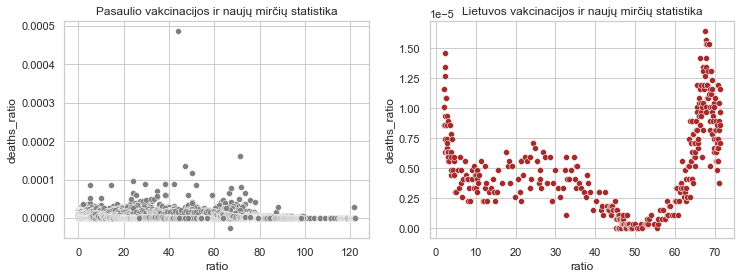

In [27]:
fig, axs = plt.subplots(1,2, figsize=(12,4)) 
sns.scatterplot(x = 'ratio', y =  'deaths_ratio', data=df, ax=axs[0], color='grey')
sns.scatterplot(x = 'ratio', y = 'deaths_ratio', data=df_Lietuva, ax=axs[1], color='brown')

axs[0].set_title("Pasaulio vakcinacijos ir naujų mirčių statistika")
axs[1].set_title("Lietuvos vakcinacijos ir naujų mirčių statistika")


## Tiesinė regresija

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [29]:
# Define x,y
X = df_Lietuva[['ratio']]
y = df_Lietuva[['deaths_ratio']]

In [30]:
#Split data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)

In [31]:
len(X_train)

274

In [32]:
len(y_train)

274

In [33]:
len(X_test)

69

In [34]:
len(X)

343

In [35]:
lm = LinearRegression()

In [36]:
lm.fit(X_train, y_train)

LinearRegression()

In [37]:
print(lm.intercept_)

[3.80596159e-06]


In [38]:
coeff_df = pd.DataFrame(lm.coef_, X.columns, columns=['Coefficients'])
coeff_df

,Coefficients
ratio,3.523269e-08


In [39]:
predictions = lm.predict(X_test)

In [40]:
predictions[0]

array([6.04488183e-06])

In [41]:
X_test

,ratio
14679,63.546676
14558,31.858918
14555,29.954382
14484,6.227539
14568,35.156005
...,...
14615,47.709567
14514,12.714998
14517,14.285928
14458,2.809787


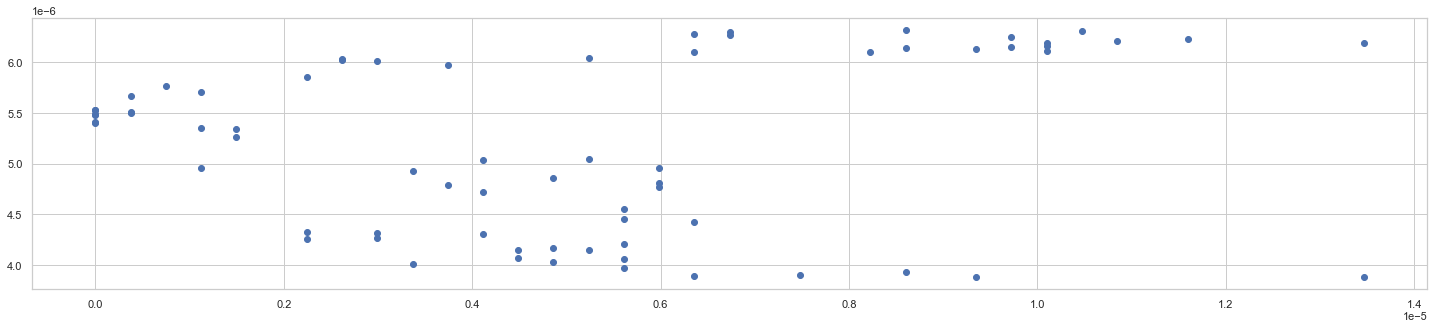

In [42]:
plt.scatter(x=y_test, y=predictions)

In [43]:
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf 

In [44]:
r2_score(y_test, predictions) #turimi duomenys mažai vienas kitą įtakoja

0.008785517133217069

Text(0.5, 1.0, 'Tiesinė regresija')

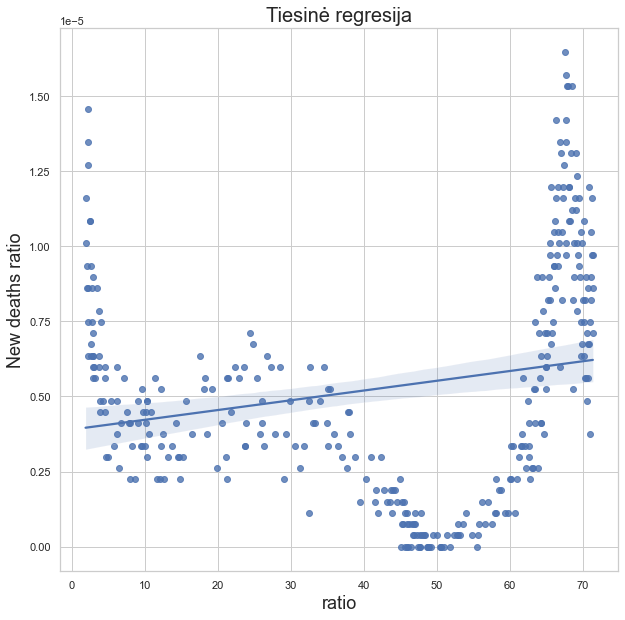

In [45]:
plt.figure(figsize=(10,10))
sns.regplot(x=X, y=y)

plt.xlabel('ratio',fontsize=18)
plt.ylabel('New deaths ratio',fontsize=18)
plt.title('Tiesinė regresija',fontsize=20)

Turimų duomenų nepakanka sukurti prognozės modeliui tarp vakcinacijos reitingo ir mirtingumo reitingo.

# GEOPANDAS

In [46]:
import geopandas as gpd

ModuleNotFoundError: No module named 'geopandas'

In [5]:
from geopandas import read_file

In [6]:
import mapclassify
mapclassify.__version__


'2.4.3'

In [49]:
import folium

ModuleNotFoundError: No module named 'folium'

In [50]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

NameError: name 'gpd' is not defined

In [48]:
table = world.merge(df, how="left", left_on=['name'], right_on=['country'])


NameError: name 'world' is not defined

In [47]:
table.columns

NameError: name 'table' is not defined

In [22]:
table1=table['country'].unique

In [23]:
table1

<bound method Series.unique of 0                       Fiji
1                       Fiji
2                       Fiji
3                       Fiji
4                       Fiji
                ...         
21357    Trinidad and Tobago
21358    Trinidad and Tobago
21359    Trinidad and Tobago
21360    Trinidad and Tobago
21361                    NaN
Name: country, Length: 21362, dtype: object>

In [24]:
table = table.dropna(subset=['ratio'])

In [20]:
my_map

<AxesSubplot:>

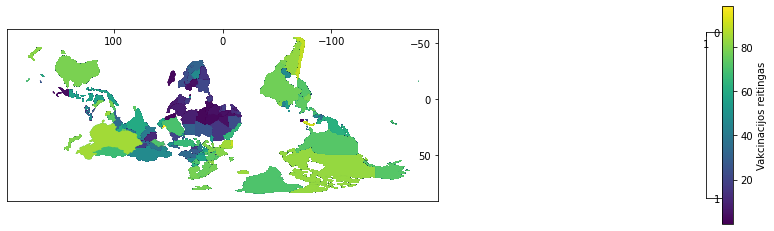

In [25]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 1)

divider = make_axes_locatable(ax)

cax = divider.append_axes("right",size="5%", pad=10)

table.plot(column='ratio', ax=ax, legend=True,legend_kwds={'label': "Vakcinacijos reitingas",
                        'orientation': "vertical"})